In [105]:
import sklearn as skl
import matplotlib.pyplot as plt
import numpy as np
import sys
from scipy.stats import mode
import scipy.integrate as integrate
import warnings
warnings.filterwarnings('ignore')

from sklearn.utils.validation import check_is_fitted
from sklearn.cluster import SpectralClustering
from scipy.io import loadmat

#Please use in all section ex

# Define the Ising model in Derrida et al., 1987

In [125]:
#part of code from https://github.com/Patrick-Louden/Ising-Model/blob/master/ising.py

import math
import random


class Ising(skl.base.BaseEstimator, skl.base.TransformerMixin):
    def __init__(self,n_spins = 1000, temperature = 1.0, sparsity = 2, seed = 117, p=2, overlap = 0.8):
        
        self.temperature = temperature
        self.n_spins = n_spins
        self.sparsity = sparsity
        self.n_C = 2
        #np.ceil(np.log(n_spins)/sparsity).astype(int) #defined as in gardner, where C << logN
        self.p = p #number of patterns
        self.seed = seed
        
        
        #choose initial condition to align with one pattern (eg. 0.8 aligned)
        self.spins = np.random.randint(2,size = (self.n_spins, 1))*2 -1 #initialize spin configuration, column vector
        #self.spins = spins
        self.overlap = overlap #quantify the amount of overal you want with the first pattern and the inital spins
    
    
    def getSpins(self):
        np.random.seed(self.seed)
        return self.spins
    
    def getConnectivity(self):
        return self.n_C
    
    def getPatterns(self):
        return self.p
    
    def getSparsity(self):
        return self.sparsity    
    
    def randomPatterns(self):
        np.random.seed(self.seed)
        
        aligned_pattern = np.copy(self.spins).reshape(1,self.n_spins,1)
             
        pattern_tensor = np.tile(aligned_pattern,(1,1,self.p-1))
        
        #Microscopic alignment patterns (scale with sqrt(N))  
        for i in range(self.p-1):
            idx_no_align_micro = random.sample(range(self.n_spins),
                                               int((1-((self.overlap)/np.sqrt(self.n_spins)))*self.n_spins))            
            pattern_tensor[:,idx_no_align_micro,i] = aligned_pattern[:,idx_no_align_micro,0]*-1
               
        #aligned pattern (macroscopic: alignment not changing with N)        
        idx_no_align_macro = random.sample(range(self.n_spins),int((1-self.overlap)*self.n_spins))
        aligned_pattern[:,idx_no_align_macro,:] = aligned_pattern[:,idx_no_align_macro,:]*-1

        pattern_tensor_full = np.concatenate((aligned_pattern, pattern_tensor), axis = 2)

        return pattern_tensor_full, aligned_pattern
        
    def randomPatternMatrix(self):
        np.random.seed(self.seed)
        patterns_1d, pattern = self.randomPatterns()
        pattern_matrix = np.tile(patterns_1d, (self.n_spins,1,1))
        return pattern_matrix

    def setTemperature(self,newTemperature):
        self.temperature = newTemperature  

    def getTemperature(self):
        return self.temperature

    def setConnectivity(self):
        np.random.seed(self.seed)
        '''
        Create the connectivity matrix C, where the probability of Cij = 1 is C/N. Note that Cij does not
        have to equal Cji. Also, there is no self-connectivity, so the diagonal of C is all 0's
        '''
        C_mat = np.random.binomial(1, self.n_C/self.n_spins, (self.n_spins,self.n_spins))
        np.fill_diagonal(C_mat, 0)#no self connectivity in the model
        return C_mat
    
    def setWeights(self):
        np.random.seed(self.seed)
        pattern_matrix = self.randomPatternMatrix()
        interactions = np.multiply(pattern_matrix, np.transpose(pattern_matrix,(1,0,2)))#look at the interactions within spins
        interacions_across_patterns = np.sum(interactions, axis = 2)#sum the interactions across patterns
        C_mat = self.setConnectivity()
        J_mat = np.multiply(C_mat, interacions_across_patterns)
        return J_mat
    
    def computeField(self):
        np.random.seed(self.seed)
        J_mat = self.setWeights()
        field_matrix = J_mat@self.spins
        return field_matrix
    
    def getProbabilitySpin(self):
        '''
        Define the probability that the spin when updated equals +1, 1-prob = spin equals -1.
        '''
       
        field = self.computeField()#get the field at time = t
        temp = self.getTemperature() #get the temperature T
        prob = (1/(1+np.exp(-2*field/temp)))
        return prob
    
    def updateSpin(self):
        '''
        Update spins based on field and the probability of the spin value
        '''
        np.random.seed(self.seed)

        spin_new = np.ones((self.n_spins,1))
        prob = self.getProbabilitySpin()
        rand_val = np.random.uniform(0,1) #if value is below prob, set spin to +1, else to -1
        
        for i in range(self.n_spins):
            prob_spin = prob[i]
            if rand_val > prob_spin:
                spin_new[i] = 1
        
        self.spins = np.copy(spin_new)
        
        
    def individualMean(self, idx):
        '''
        Calculate the interaction between an individual spin and the corresponding value in pattern 1
        
        Arguments:
            idx (int): index at which you want to compute the interaction
            pattern(int): pattern index with which you are looking at the overlap
           
        '''
        np.random.seed(self.seed)
        patterns, pattern = self.randomPatterns()
        individual_pattern = pattern[:,idx,:]
        
        spins = self.spins
        individual_spin = spins[idx]
        
        individual_mean = np.int(individual_pattern)*np.int(individual_spin)
        
        return individual_mean
    
    def averageMean(self):
        '''
        Calculate the averge mean field for all spins
        
        Arguments:
            pattern(int): pattern index with which you are looking at the overlap
        
        '''
        np.random.seed(self.seed)
        #patterns, pattern = self.randomPatterns()#define the matrix of patterns and the one that will align
        normalization = 1/self.n_spins
        avg_mean = 0
        
        for idx in range(self.n_spins):
            indiv_mean = self.individualMean(idx)
            avg_mean += indiv_mean
            
        avg_mean_norm = normalization*avg_mean
        
        return np.float64(avg_mean_norm)
    
    def averageMeanAllPatterns(self):
        
        np.random.seed(self.seed)
        patterns, pattern = self.randomPatterns()
        
        normalization = 1/self.n_spins
        print(patterns[0,:,:].T.shape)
        print(self.spins.shape)
        means = normalization*patterns[0,:,:].T@self.spins
        
        return means
    
        
    def simulateMeans(self,epochs):
        '''
        Run a simulation with a fixed temperature and capacity (alpha) for a certain amount of epochs
        '''
        
        np.random.seed(self.seed)
    
        patterns, aligned_pattern = self.randomPatterns()
        init_mean = np.copy(self.averageMean()).item()
        means = [init_mean]

        for e in range(epochs):
            self.updateSpin()
            mean_new = np.copy(self.averageMean()).item()
            means.append(mean_new)

        return means




In [126]:
def analyticUpdate(m, a, T, epochs):
    '''
    Function takes the mean magnetization and returns a fixed temperature and capacity and returns the mean at the 
    next time step.
    '''
    
    f_m = [m]
   
    for e in range(epochs):
        
        g = lambda x: (np.exp(-x**2)*np.tanh((f_m[e]-x*np.sqrt(2*a))/T))/np.sqrt(np.pi) #euqation (18) in Derrida 1987 paper
        f = integrate.quad(g, -np.inf, np.inf)
        f_m.append(f[0])
        
    return f_m
    
    
    

In [92]:
IS = Ising(n_spins = 100)
prob= IS.getProbabilitySpin()
spins = IS.getSpins()
J_mat = IS.setWeights()
C_mat = IS.setConnectivity()
C_constant = IS.getConnectivity()

rand_patterns, rand_pattern = IS.randomPatterns()

indiv_mean = IS.individualMean(3)
all_means = IS.averageMeanAllPatterns()

(10, 100)
(100, 1)


In [104]:
#print(rand_patterns)
print(all_means)
#print(rand_patterns[0,:,2].T@rand_patterns[0,:,3])
print(rand_patterns[0,:,7].T@spins)

[[ 0.62]
 [-0.84]
 [-0.84]
 [-0.84]
 [-0.84]
 [-0.84]
 [-0.84]
 [-0.84]
 [-0.84]
 [-0.84]]
[-84]


In [127]:
#Check that all probabilities are between 0 and 1

print("Probability wrong in :")
print(np.where(prob > 1))
print(np.where(prob <0))

Probability wrong in :
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))


In [128]:
#run simulation for T = t

def run_sim(epochs, IS):
    
    patterns, aligned_pattern = IS.randomPatterns()
    init_mean = np.copy(IS.averageMean()).item()
    means = [init_mean]
    
    for e in range(epochs):
        IS.updateSpin()
        mean_new = np.copy(IS.averageMean()).item()
        means.append(mean_new)
    
    return means
        
    

In [129]:
IS = Ising(seed = 13)
means = IS.simulateMeans(100)#argument is number of epochs
C = IS.getConnectivity()
p = IS.getPatterns()

alpha = (p-1)/C

print(means)

[0.63, 0.594, 0.578, 0.5760000000000001, 0.588, 0.5720000000000001, 0.64, 0.622, 0.624, 0.654, 0.586, 0.552, 0.612, 0.612, 0.606, 0.6, 0.594, 0.602, 0.608, 0.604, 0.612, 0.558, 0.612, 0.624, 0.602, 0.616, 0.636, 0.598, 0.622, 0.604, 0.61, 0.588, 0.588, 0.58, 0.616, 0.592, 0.624, 0.592, 0.592, 0.64, 0.586, 0.622, 0.622, 0.582, 0.602, 0.5740000000000001, 0.6, 0.5740000000000001, 0.612, 0.596, 0.618, 0.58, 0.64, 0.61, 0.596, 0.59, 0.632, 0.594, 0.644, 0.558, 0.654, 0.592, 0.562, 0.626, 0.582, 0.61, 0.634, 0.5680000000000001, 0.584, 0.634, 0.67, 0.598, 0.56, 0.614, 0.62, 0.5660000000000001, 0.632, 0.596, 0.598, 0.624, 0.616, 0.658, 0.616, 0.622, 0.604, 0.5660000000000001, 0.586, 0.598, 0.65, 0.598, 0.612, 0.592, 0.598, 0.5720000000000001, 0.5760000000000001, 0.608, 0.62, 0.644, 0.5700000000000001, 0.594, 0.5760000000000001]


In [130]:
analytic_means = analyticUpdate(means[0], alpha, 1.0, 100)

In [131]:
print(analytic_means)

[0.63, 0.4320172601259291, 0.30529113380361267, 0.21870251028088822, 0.15772470187562784, 0.11413613494189313, 0.08273919087203706, 0.06003420403103992, 0.04358086365358, 0.03164485942828764, 0.022980982560579667, 0.016690318873774205, 0.012122070938446555, 0.008804354572051903, 0.006394737468231244, 0.004644621031185228, 0.003373487453418465, 0.0024502397079374898, 0.0017796655592936352, 0.0012926126497306333, 0.0009388549584526239, 0.000681912510185746, 0.0004952891777496657, 0.00035974025107459004, 0.00026128786230653723, 0.0001897795629114895, 0.00013784139207239848, 0.00010011746852574545, 7.271768927106117e-05, 5.281658050806913e-05, 3.8361933740820694e-05, 2.786318134318864e-05, 2.0237688743461457e-05, 1.4699112806096205e-05, 1.0676313883039078e-05, 7.754459669871615e-06, 5.632247743094158e-06, 4.090834950470934e-06, 2.9712703267610582e-06, 2.158104020736837e-06, 1.567482070655095e-06, 1.1384993578864169e-06, 8.269190520324413e-07, 6.00610895239846e-07, 4.3623792027282314e-07, 3

In [25]:
#run simulation for different temperatures and look at the last magnetization value for each simulation

def run_simulation_temp(t_array, epochs):
    '''
    Runs the simulation of parallel mean field updates.
    
    Arguments:
        t_array(np.array): array with the different temperature values
        epochs(int): number of epochs you want to run each individual simulation for
    '''
    magnetization = []
    stdev = []
    for t in t_array:
        IS = Ising(temperature = t)
        means = IS.simulateMeans(epochs)
        mean_means = np.mean(means)
        std = np.std(means)
        magnetization.append(mean_means)
        stdev.append(std)
        
    return magnetization, stdev

        
        

In [28]:
#run simulation for different temperatures

t_array = np.linspace(0.01, 100, num = 100)
epochs = 50

magnetization, std = run_simulation_temp(t_array, epochs)
        

0.054252017734097206 0.005396005941633721


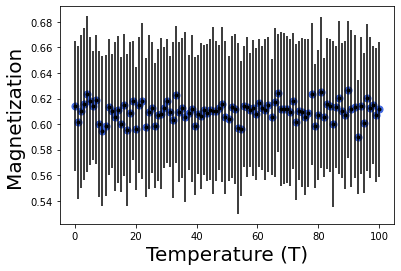

In [29]:
#plot simulation results     


plt.scatter(t_array, magnetization, s=50, marker='o', color='RoyalBlue')
plt.errorbar(t_array, magnetization, yerr=std, fmt='.k')
plt.xlabel("Temperature (T)", fontsize=20); 
plt.ylabel("Magnetization ", fontsize=20);   plt.axis('tight')

print(np.mean(std),np.std(std))

# Simulation 2: fix T to 0.01 and look at alpha and magnetization (keep number of patterns fixed)

### Assume there are 10 patterns



In [7]:
p = 10

IS = Ising(seed= 777, p = p)
sparsity_factor = IS.getSparsity() #divides log(N) to set C in the class
C_critical = ((p-1)*np.pi)/2 #in Derrida paper alpha_c is determined to be 2/pi analytically

N_critical = np.exp(C_critical*sparsity_factor)#change value of N to change the value of C

In [11]:
C_critical

14.137166941154069

In [57]:
N_range = np.linspace(100, N_critical, num = 100)

In [64]:
#run simulation for different alpha values by variying N and look at the last magnetization value for each simulation

def run_simulation_n(n_array, temperature, epochs):
    '''
    Runs the simulation of parallel mean field updates.
    
    Arguments:
        n_array(np.array): array with the different n_spin values
        temperature(float): value of the temperature to run the simulations with
        epochs(int): number of epochs you want to run each individual simulation for
    '''
    magnetization = []
    stdev = []
    for n in n_array:
        IS = Ising(n_spins = int(n), temperature = temperature)
        means = IS.simulateMeans(epochs)
        mean_means = np.mean(means)
        std = np.std(means)
        magnetization.append(mean_means)
        stdev.append(std)
        
    return magnetization, stdev

In [ ]:
magnetization, std = run_simulation_n(N_range, 0.01, 100)

# Simulation 2: fix T to 0.01 and look at alpha and magnetization (keep C and N fixed)


In [12]:
IS = Ising(n_spins = 500, seed= 777)
C_const = IS.getConnectivity()
p_critical = (2*C_const)/np.pi -1

In [13]:
p_critical

1.5464790894703255

In [19]:
int(np.round(p_critical))

2

In [30]:
p_range = np.linspace(1,20, num = 20).astype(int)

In [36]:
alpha_range = (p_range -1)/C_const

In [38]:
alpha_range, C_const, 2/np.pi

(array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 ,
        2.75, 3.  , 3.25, 3.5 , 3.75, 4.  , 4.25, 4.5 , 4.75]),
 4,
 0.6366197723675814)

In [32]:
#run simulation for different alpha values by variying N and look at the last magnetization value for each simulation

def run_simulation_p(p_array, temperature, epochs):
    '''
    Runs the simulation of parallel mean field updates.
    
    Arguments:
        p_array(np.array): array with different pattern amounts
        temperature(float): value of the temperature to run the simulations with
        epochs(int): number of epochs you want to run each individual simulation for
    '''
    magnetization = []
    stdev = []
    for p in p_array:
        IS = Ising(p = p, temperature = temperature)
        means = IS.simulateMeans(epochs)
        mean_means = np.mean(means)
        std = np.std(means)
        magnetization.append(mean_means)
        stdev.append(std)
        
    return magnetization, stdev

In [34]:
magnetization, std = run_simulation_p(p_range, 0.01, 100)

0.05700973789900228 0.004191004946056291


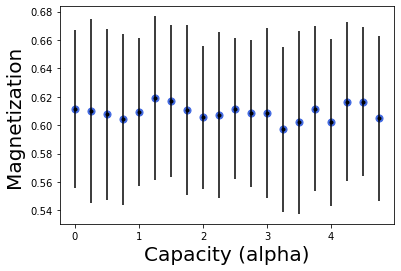

In [39]:
#plot simulation results     


plt.scatter(alpha_range, magnetization, s=50, marker='o', color='RoyalBlue')
plt.errorbar(alpha_range, magnetization, yerr=std, fmt='.k')
plt.xlabel("Capacity (alpha)", fontsize=20); 
plt.ylabel("Magnetization ", fontsize=20);   plt.axis('tight')

print(np.mean(std),np.std(std))

In [4]:
1/np.sqrt(np.pi)

0.5641895835477563

In [7]:
2/np.sqrt(np.pi)

1.1283791670955126